In [3]:
import pandas as pd

# CARGA DE DATOS CSV
refrigerador_df = pd.read_csv('refrigerador.csv')
ventilador_df = pd.read_csv('ventilador.csv')


# AGREGAR COLUMNA DE ETIQUETA POR CADA DISPOSITIVO
refrigerador_df['dispositivo'] = 'refrigerador'
ventilador_df['dispositivo'] = 'ventilador'


# COMBINAR DATO EN UN SOLO DATAFRAME
datos_combinados = pd.concat([refrigerador_df, ventilador_df])

# GUARDAR ARCHIVO
datos_combinados.to_csv('datos_combinados2.csv', index=False)

print(datos_combinados.head())

                fecha  Corriente_linea1   dispositivo
0  2024-09-25_10-00-0          0.319056  refrigerador
1  2024-09-25_10-00-1          0.321618  refrigerador
2  2024-09-25_10-00-2          0.320952  refrigerador
3  2024-09-25_10-00-3          0.318872  refrigerador
4  2024-09-25_10-00-3          0.318872  refrigerador


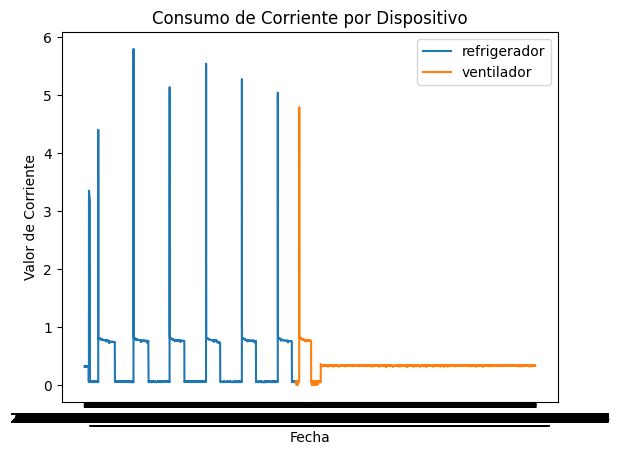

In [5]:
import matplotlib.pyplot as plt

#VISUALIZACION DE CONSUMO POR CADA DISPOSITIVO
for dispositivo in datos_combinados['dispositivo'].unique():
    subset = datos_combinados[datos_combinados['dispositivo'] == dispositivo]
    plt.plot(subset['fecha'], subset['Corriente_linea1'], label=dispositivo)

plt.xlabel('Fecha')
plt.ylabel('Valor de Corriente')
plt.title('Consumo de Corriente por Dispositivo')
plt.legend()
plt.show()


In [6]:
#EXTRACCION DE CARACTERISTICAS DE CADA DISPOSITIVO, MEDIA, DESVIACION Y PICOS

# Calcular características estadísticas de corriente
def extraer_caracteristicas(df):
    df['media_corriente'] = df['Corriente_linea1'].rolling(window=5).mean()  # Media en una ventana de 5 muestras
    df['desviacion_corriente'] = df['Corriente_linea1'].rolling(window=5).std()  # Desviación estándar
    df['corriente_max'] = df['Corriente_linea1'].rolling(window=5).max()  # Corriente máxima
    df['corriente_min'] = df['Corriente_linea1'].rolling(window=5).min()  # Corriente mínima
    df = df.dropna()  # Elimina valores NaN generados por la ventana de tiempo
    return df

# Aplicar la extracción de características
datos_combinados = extraer_caracteristicas(datos_combinados)

# Selección de características y etiquetas
X = datos_combinados[['media_corriente', 'desviacion_corriente', 'corriente_max', 'corriente_min']]
y = datos_combinados['dispositivo']

In [7]:
#DIVISION DE DATOS

from sklearn.model_selection import train_test_split

# Dividir los datos en entrenamiento (80%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

[[1561   17]
 [  90 1661]]
              precision    recall  f1-score   support

refrigerador       0.95      0.99      0.97      1578
  ventilador       0.99      0.95      0.97      1751

    accuracy                           0.97      3329
   macro avg       0.97      0.97      0.97      3329
weighted avg       0.97      0.97      0.97      3329



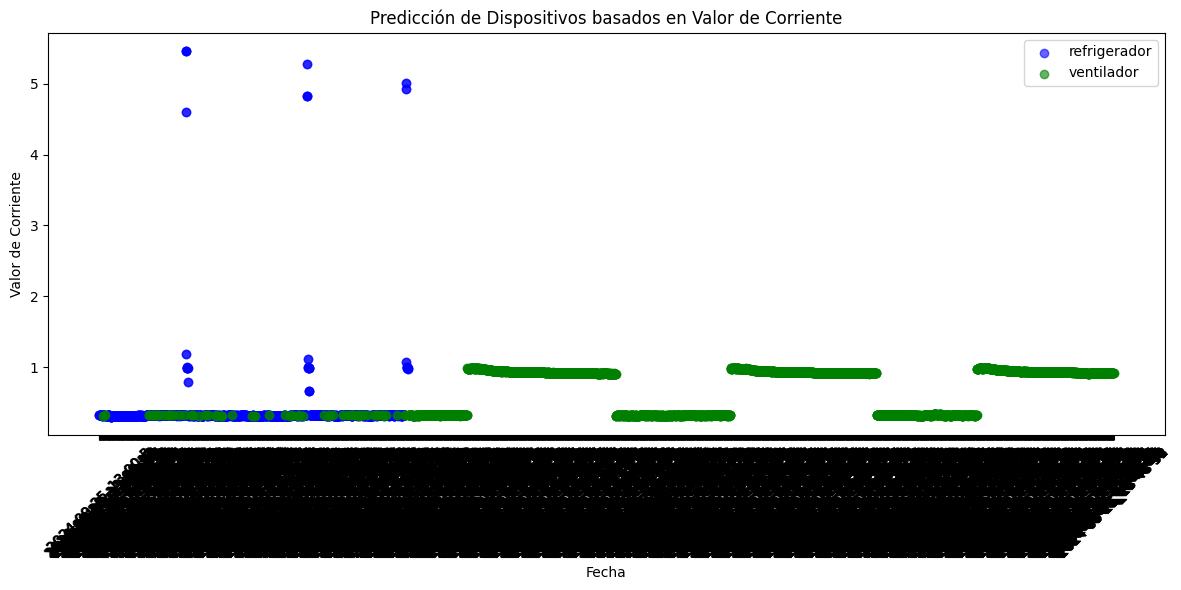

In [9]:
#ENTRENAMIENTO DEL MODELO RANDOM FOREST

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Crear el modelo de Random Forest
modelo_rf = RandomForestClassifier(n_estimators=100, random_state=42)

# Entrenar el modelo
modelo_rf.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred = modelo_rf.predict(X_test)

# Evaluar el modelo
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
#PREDICCION CON NUEVOS DATOS

# Cargar nuevos datos
datos_generales = pd.read_csv('datos_generales2.csv')

# Extraer características
datos_generales = extraer_caracteristicas(datos_generales)

# Predecir el dispositivo de cada registro
X_nuevos = datos_generales[['media_corriente', 'desviacion_corriente', 'corriente_max', 'corriente_min']]
predicciones = modelo_rf.predict(X_nuevos)

# Agregar las predicciones al DataFrame
datos_generales['dispositivo_predicho'] = predicciones

# Guardar los resultados en un archivo CSV
datos_generales.to_csv('datos_predicciones2.csv', index=False)#VISUALIZACION
import matplotlib.pyplot as plt

# Configurar colores para cada dispositivo
colores = {'refrigerador': 'blue', 'ventilador': 'green'}

# Crear la gráfica de dispersión
plt.figure(figsize=(12, 6))
for dispositivo in datos_generales['dispositivo_predicho'].unique():
    subset = datos_generales[datos_generales['dispositivo_predicho'] == dispositivo]
    plt.scatter(subset['fecha'], subset['Corriente_linea1'], label=dispositivo, color=colores[dispositivo], alpha=0.6)

# Configurar etiquetas y título
plt.xlabel('Fecha')
plt.ylabel('Valor de Corriente')
plt.title('Predicción de Dispositivos basados en Valor de Corriente')
plt.xticks(rotation=45)
plt.legend()

# Mostrar la gráfica
plt.tight_layout()
plt.show()

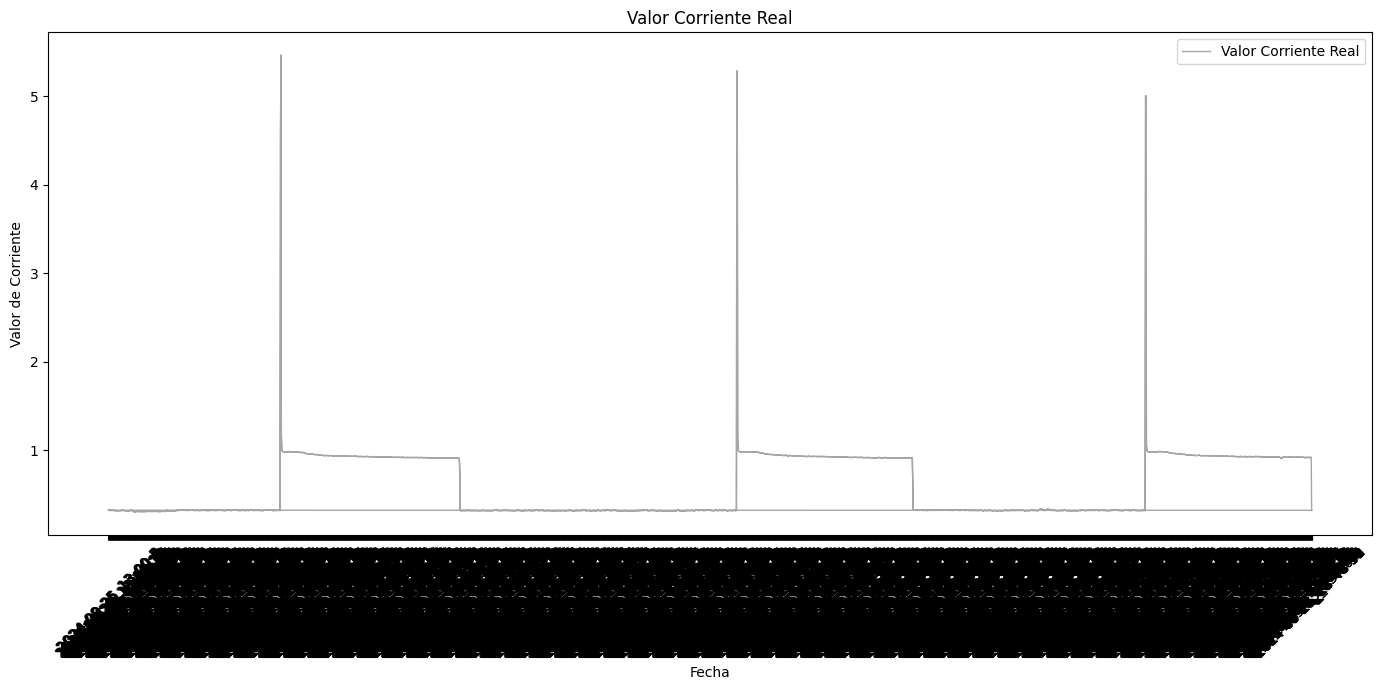

In [12]:
import matplotlib.pyplot as plt

# Crear la gráfica de líneas
plt.figure(figsize=(14, 7))

# Graficar las corrientes reales (sin etiqueta de dispositivo)
plt.plot(datos_generales['fecha'], datos_generales['Corriente_linea1'], label='Valor Corriente Real', color='gray', alpha=0.7, linewidth=1)

# Configurar etiquetas y título
plt.xlabel('Fecha')
plt.ylabel('Valor de Corriente')
plt.title('Valor Corriente Real')
plt.xticks(rotation=45)
plt.legend()

# Ajustar el diseño para que todo encaje
plt.tight_layout()

# Mostrar la gráfica
plt.show()


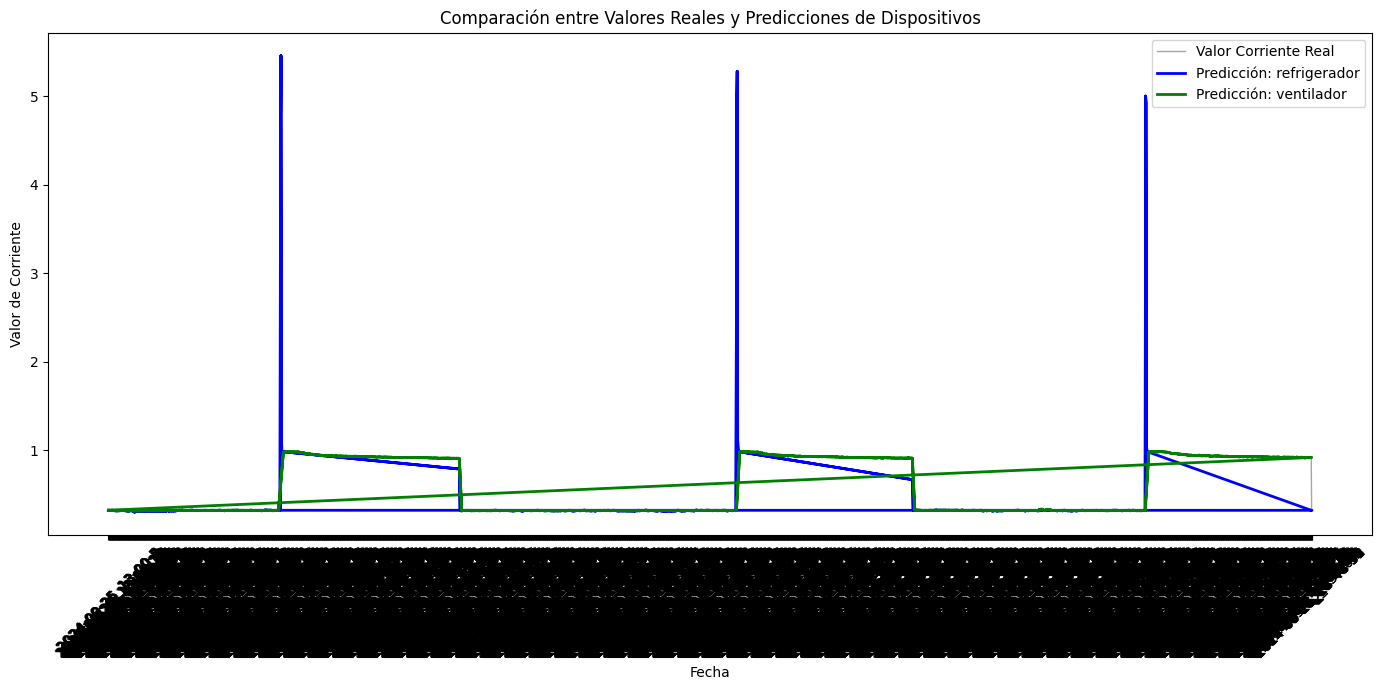

In [11]:
import matplotlib.pyplot as plt

# Configurar colores más fuertes para cada dispositivo
colores_prediccion = {'refrigerador': 'blue', 'ventilador': 'green'}

# Crear la gráfica de líneas
plt.figure(figsize=(14, 7))

# Graficar las corrientes reales (sin etiqueta de dispositivo)
plt.plot(datos_generales['fecha'], datos_generales['Corriente_linea1'], label='Valor Corriente Real', color='gray', alpha=0.7, linewidth=1)

# Graficar las predicciones con colores más fuertes y líneas continuas
for dispositivo in datos_generales['dispositivo_predicho'].unique():
    subset = datos_generales[datos_generales['dispositivo_predicho'] == dispositivo]
    plt.plot(subset['fecha'], subset['Corriente_linea1'], label=f'Predicción: {dispositivo}', color=colores_prediccion[dispositivo], linewidth=2)

# Configurar etiquetas y título
plt.xlabel('Fecha')
plt.ylabel('Valor de Corriente')
plt.title('Comparación entre Valores Reales y Predicciones de Dispositivos')
plt.xticks(rotation=45)
plt.legend()

# Ajustar el diseño para que todo encaje
plt.tight_layout()

# Mostrar la gráfica
plt.show()
